In [1]:
!pip install supervision==0.3.0
!pip install transformers
!pip install pycocotools
!pip install scipy
!pip install pytorch-lightning
!pip install coco-eval
! pip install tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.2/426.2 kB 8.8 MB/s eta 0:00:00:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for coco-eval: filename=coco_eval-0.0.4-py3-none-any.whl size=5017 sha256=e81bd72648066512f999fcf8debe134ed6629cfc0405fad283a39afe14cddee6
  Stored in directory: /root/.cache/pip/wheels/84/b3/4e/028c9f6224a7d8a3ed8023224283820e90d489010f3c77ea13
Successfully built coco-eval


In [2]:
import os
import torch
import torchvision
import supervision as sv
import transformers

In [3]:
device = "cuda"

In [4]:
dataset = "/kaggle/input/pcb-coco/PCB_COCO"

ANNOTATION_FILE_NAME = "_annotations.coco.json"
# TRAIN_DIR = os.path.join(dataset, "train")
# VAL_DIR = os.path.join(dataset, "valid")
TEST_DIR = os.path.join(dataset, "test")

In [5]:
class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_dir_path: str, processor, train: bool=True):
        ann_file = os.path.join(img_dir_path, ANNOTATION_FILE_NAME)
        super(CocoDetection, self).__init__(img_dir_path, ann_file)
        self.processor = processor
        
    def __getitem__(self, idx):
        img, target = super(CocoDetection, self).__getitem__(idx)
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.processor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze() # remove batch dimension
        target = encoding["labels"][0] # remove batch dimension

        return pixel_values, target

In [6]:
from transformers import DetrImageProcessor
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
test_dataset = CocoDetection(TEST_DIR, processor=processor, train=False)

2024-05-27 18:27:46.581162: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-27 18:27:46.581262: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-27 18:27:46.713589: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


preprocessor_config.json:   0%|          | 0.00/290 [00:00<?, ?B/s]

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [7]:
from transformers import DetrForObjectDetection
MODEL_PATH = '/kaggle/input/detr-pcb/pytorch/detr-pcb/1/detr-finetuned-pcb'
model = DetrForObjectDetection.from_pretrained(MODEL_PATH)
model.to(device)

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): FeatureListNet(
          (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (bn1): DetrFrozenBatchNorm2d()
          (act1): ReLU(inplace=True)
          (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (layer1): Sequential(
            (0): Bottleneck(
              (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn1): DetrFrozenBatchNorm2d()
              (act1): ReLU(inplace=True)
              (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn2): DetrFrozenBatchNorm2d()
              (drop_block): Identity()
              (act2): ReLU(inplace=True)
              (aa): Identity()
              (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      

In [8]:
# set up classes of target and create instance box annotator for drawing box in image
categories = test_dataset.coco.cats
id2label = {k: v['name'] for k,v in categories.items()}
box_annotator = sv.BoxAnnotator()

In [9]:
import random
import cv2 as cv

# select random image
image_ids = test_dataset.coco.getImgIds()
# image_id = random.choice(image_ids)
image_id = 127
print('Image #{}'.format(image_id))

# load image and its annotations
image = test_dataset.coco.loadImgs(image_id)[0]
annotations = test_dataset.coco.imgToAnns[image_id]
image_path = os.path.join(test_dataset.root, image['file_name'])
image = cv.imread(image_path)

# annotate ground truth
detections = sv.Detections.from_coco_annotations(coco_annotation=annotations)
labels = [f"{id2label[_]}" for _ in detections.class_id]
frame_ground_truth = box_annotator.annotate(scene=image.copy(), detections=detections, 
                                            labels=labels)

Image #127


In [10]:
# predict and annotate detections
confindence_threshold = 0.08
with torch.no_grad():

    # load image and predict
    inputs = processor(images=image, return_tensors='pt').to(device)
    outputs = model(**inputs)

    # post-process
    target_sizes = torch.tensor([image.shape[:2]]).to(device)
    results = processor.post_process_object_detection(
        outputs=outputs, 
        threshold=confindence_threshold, 
        target_sizes=target_sizes
    )[0]


    detections = sv.Detections.from_transformers(transformers_results=results)
    labels = [f"{id2label[class_id]} {confidence:.2f}" for _, confidence, class_id, _ in detections]
    frame_detections = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)

In [11]:
detections

Detections(xyxy=array([[1217.8356 , 1118.1432 , 1331.3915 , 1222.9368 ],
       [1121.8428 ,  882.42523, 1243.3376 ,  979.82916],
       [ 966.624  , 1200.7247 , 1095.5262 , 1325.507  ],
       [ 881.07935,  989.1605 ,  996.90424, 1090.6531 ],
       [ 895.9409 ,  735.77545, 1015.30853,  862.2203 ],
       [1420.7668 ,  998.8179 , 1534.7013 , 1097.8892 ],
       [1177.048  ,  824.7511 , 1325.4626 ,  936.81384],
       [1091.5051 , 1177.317  , 1214.0425 , 1288.1624 ],
       [1503.1589 ,  865.7466 , 1625.7367 ,  964.4236 ]], dtype=float32), class_id=array([2, 2, 2, 2, 2, 2, 2, 2, 2]), confidence=array([0.08133742, 0.08962713, 0.08073898, 0.08683377, 0.08350198,
       0.08040753, 0.09178959, 0.08225458, 0.08172866], dtype=float32), tracker_id=None)

Text(0.5, 1.0, 'Detections')

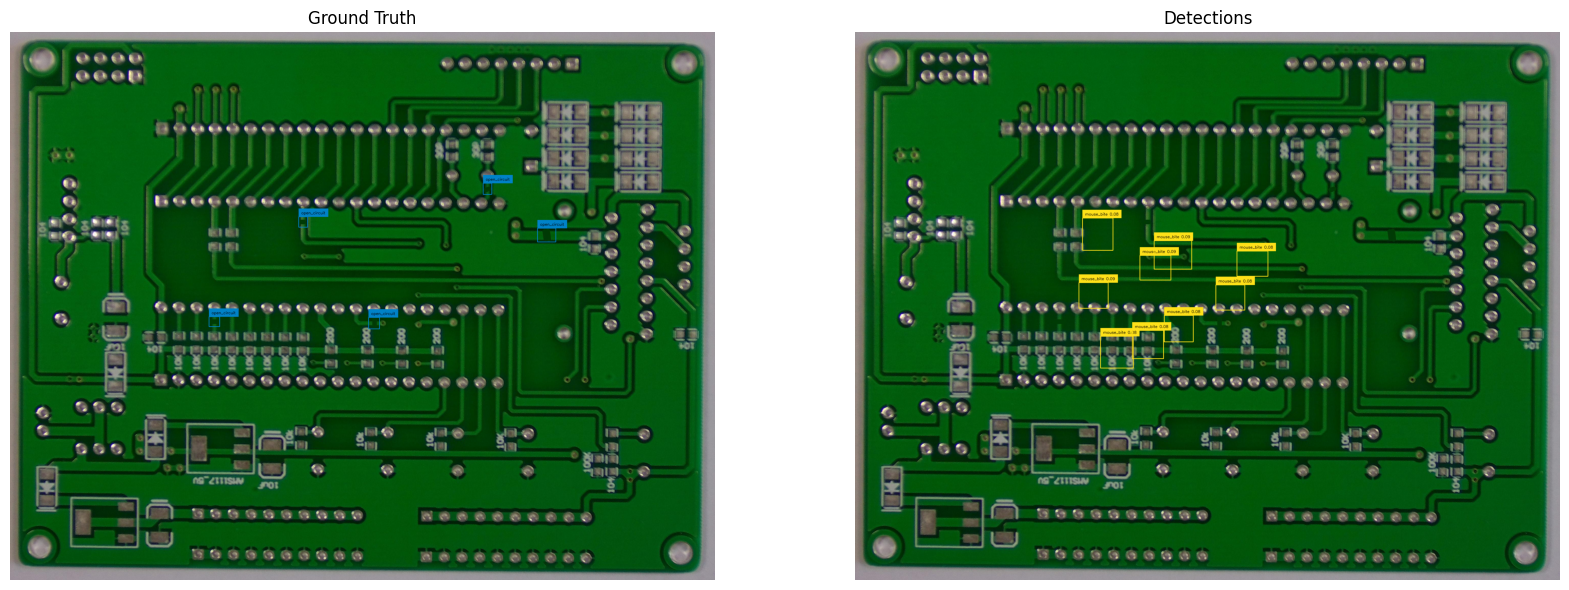

In [12]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(cv.cvtColor(frame_ground_truth, cv.COLOR_BGR2RGB))
axs[0].axis('off')
axs[0].set_title('Ground Truth')

axs[1].imshow(cv.cvtColor(frame_detections, cv.COLOR_BGR2RGB))
axs[1].axis('off')
axs[1].set_title('Detections')

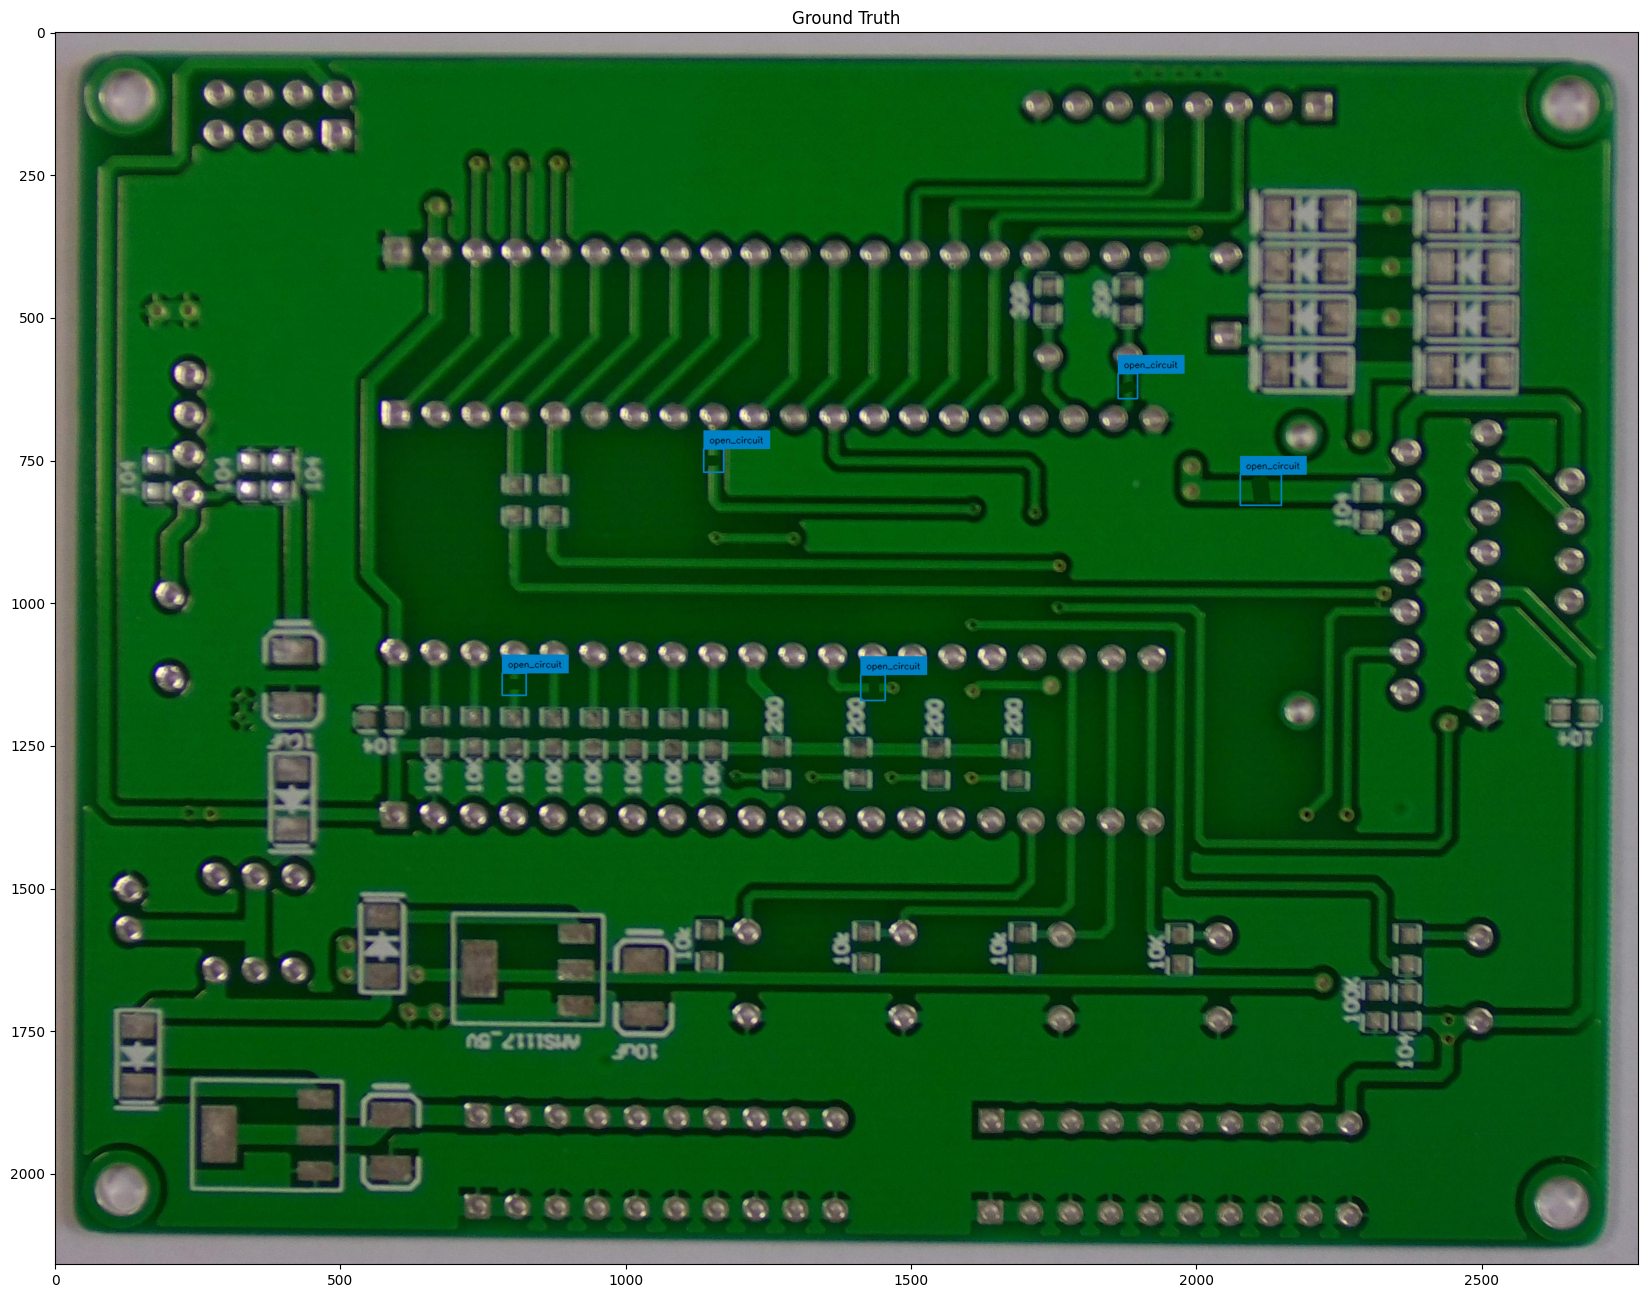

In [13]:
plt.figure(figsize=(32, 16))
plt.imshow(cv.cvtColor(frame_ground_truth, cv.COLOR_BGR2RGB))
plt.title("Ground Truth")
plt.show()

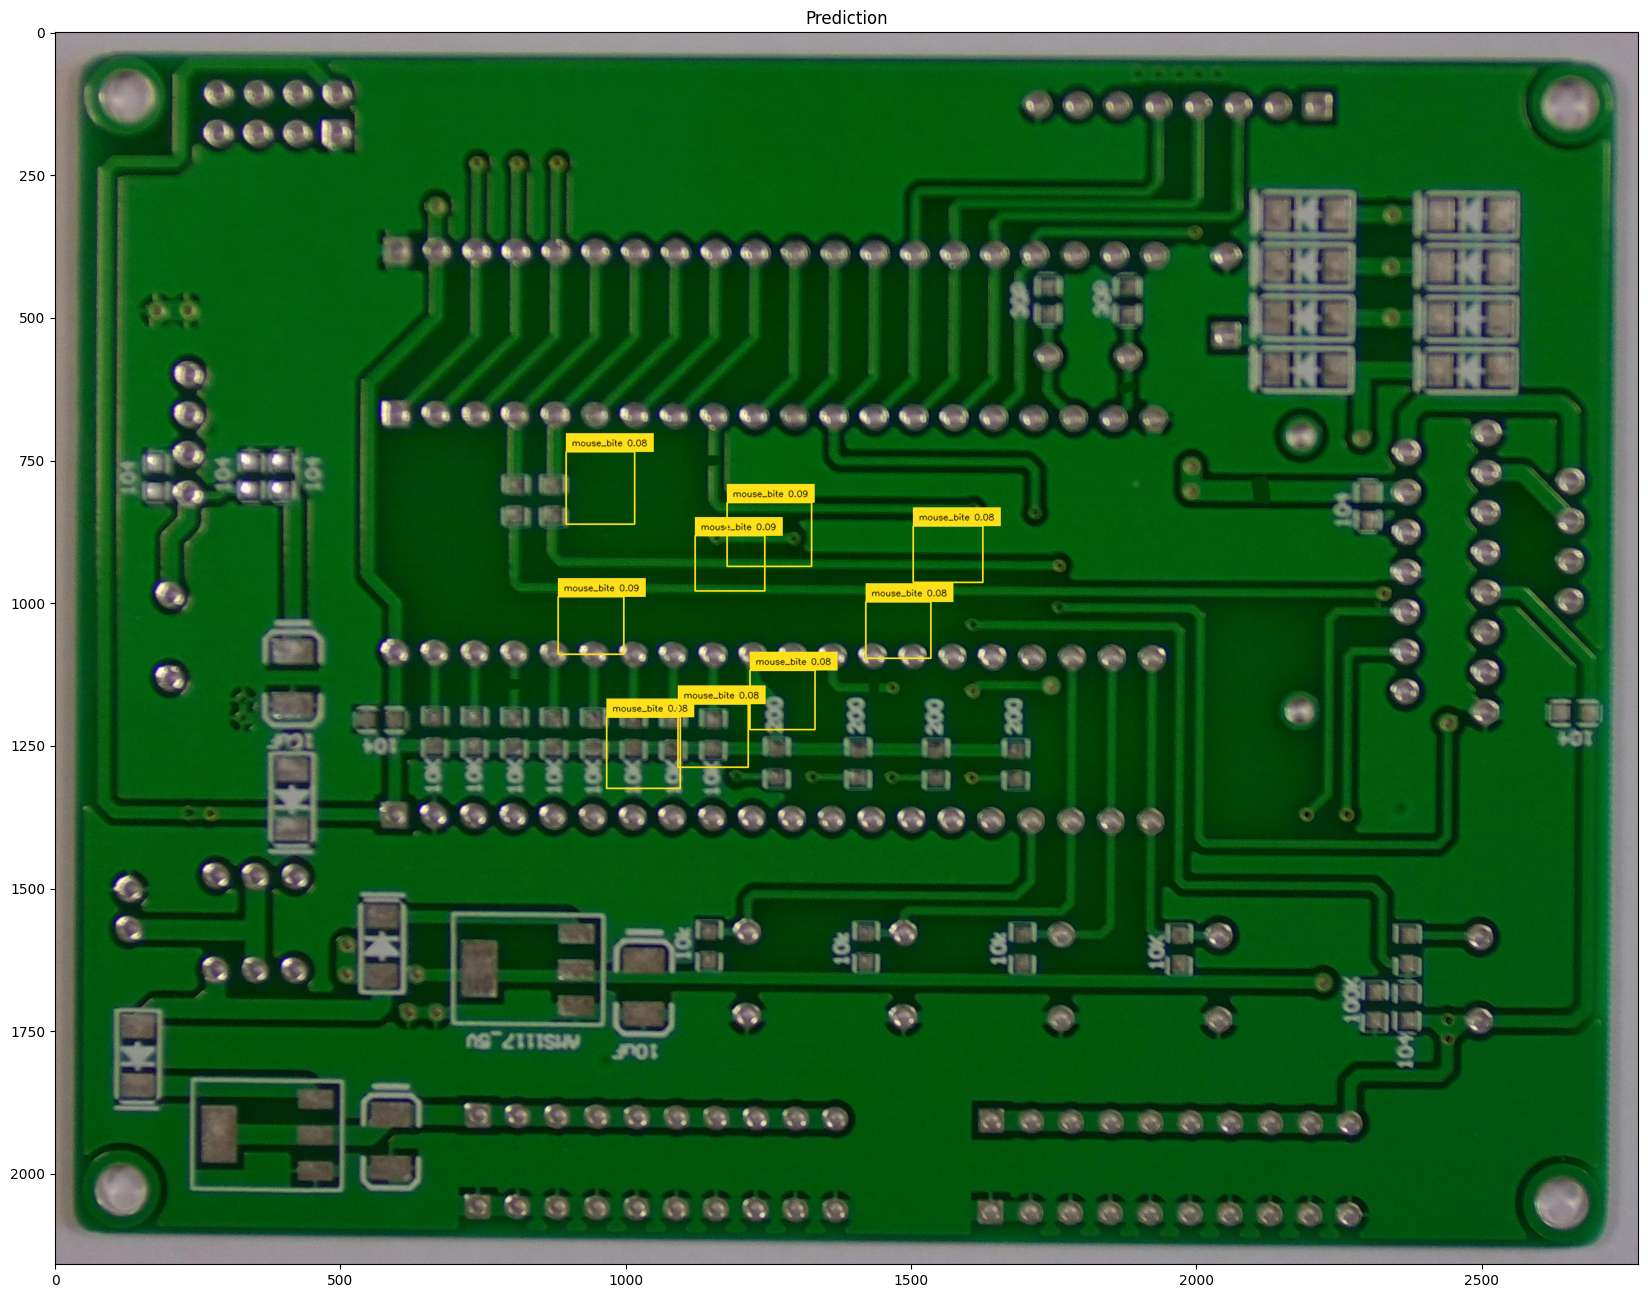

In [14]:
plt.figure(figsize=(32, 16))
plt.imshow(cv.cvtColor(frame_detections, cv.COLOR_BGR2RGB))
plt.title("Prediction")
plt.show()

In [18]:
def convert_to_xywh(boxes):
    xmin, ymin, xmax, ymax = boxes.unbind(1)
    return torch.stack((xmin, ymin, xmax - xmin, ymax - ymin), dim=1)

def prepare_for_coco_detection(predictions):
    coco_results = []
    for original_id, prediction in predictions.items():
        if len(prediction) == 0:
            continue

        boxes = prediction["boxes"]
        boxes = convert_to_xywh(boxes).tolist()
        scores = prediction["scores"].tolist()
        labels = prediction["labels"].tolist()

        coco_results.extend(
            [
                {
                    "image_id": original_id,
                    "category_id": labels[k],
                    "bbox": box,
                    "score": scores[k],
                }
                for k, box in enumerate(boxes)
            ]
        )
    return coco_results

In [20]:
from coco_eval import CocoEvaluator
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader
import numpy as np


def collate_fn(batch):
    pixel_values = [item[0] for item in batch]
    encoding = processor.pad(pixel_values, return_tensors="pt")
    labels = [item[1] for item in batch]
    batch = {}
    batch['pixel_values'] = encoding['pixel_values']
    batch['pixel_mask'] = encoding['pixel_mask']
    batch['labels'] = labels
    return batch

# initialize evaluator with ground truth (gt)
evaluator = CocoEvaluator(coco_gt=test_dataset.coco, iou_types=["bbox"])
test_dataloader = DataLoader(test_dataset, collate_fn=collate_fn, batch_size=4, num_workers=2)

print("Running testing...")
for idx, batch in enumerate(tqdm(test_dataloader)):
    # get the inputs
    pixel_values = batch["pixel_values"].to(device)
    pixel_mask = batch["pixel_mask"].to(device)
    labels = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]] # these are in DETR format, resized + normalized

    # forward pass
    with torch.no_grad():
        outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    # turn into a list of dictionaries (one item for each example in the batch)
    orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
    results = processor.post_process_object_detection(outputs, 
                                                      target_sizes=orig_target_sizes, 
                                                      threshold=0.00)

    # provide to metric
    # metric expects a list of dictionaries, each item
    # containing image_id, category_id, bbox and score keys
    predictions = {target['image_id'].item(): output for target, output in zip(labels, results)}
    predictions = prepare_for_coco_detection(predictions)
    evaluator.update(predictions)

evaluator.synchronize_between_processes()
evaluator.accumulate()
evaluator.summarize()

Running testing...


  0%|          | 0/35 [00:00<?, ?it/s]

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


Accumulating evaluation results...
DONE (t=0.23s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la